<div class="alert alert-block alert-warning">
    You can <b>read</b> this Jupyter notebook on my GitHub, but to <b>run the embedded code</b> you'll need to clone the epidemics directory to your local machine. 
</div>

# Background: the SIR model
A common way to model epidemics is to divide a population into compartments, between which individuals move as their infection status changes. A common compartmental model is __[the SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model)__, which stands for **S**usceptible, **I**nfectious, **R**ecovered. Individuals start off susceptible in S, are infected at a given rate and move to I, then recover at a given rate and move to R, where they remain.

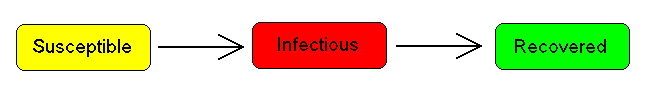

So we have three compartments (S, I, R) and two parameters (infection rate and recovery rate). This is often modelled using differential equations, but here we're going to simulate infections on a networked population.

A naive approach would be to start at time zero with some randomly infected nodes, then find each neighbour of an infected node, then calculate its probability of infection, then change its status if infected, then advance one timestep and repeat…

This turns out to be quite inefficient. A lot of the time we do multiple calculations, only for few nodes to actually change status. And we have to repeat all the calculations at each timestep. There is a much more efficient method, using an event queue, which is what we’ll implement below.

<div class="alert alert-block alert-info">
If you want to model epidemics on networks with Python, you can simply use the excellent (and appropriately named) package Epidemics on Networks (<strong>pip install EoN</strong>), which contains over 100 functions and is built and maintained by active researchers in the field. If however, like me, you like to learn how things work by building them yourself, then read on…
</div>

## Importing packages and initialising variables
We’ll be using the Python modules NumPy, Pandas, Random, and NetworkX, so let's start by importing them all:

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import random

Now let's also initialise some variables:

In [2]:
i_rate = 0.5 # the per edge infection rate
r_rate = 1 # the recovery rate
init = 1 # the number of initial infections
max_time = 20 # just in case we do something wrong, it will stop!

Because the flow is one-way through an SIR model (see diagram above), the model will always reach an equilibrium with no infections and it should never loop forever. But, belt-and-braces.

For our population, you can import network data from a csv and pass it to NetworkX in several ways, but for our purposes we can just get NetworkX to generate a random network for us, such as:

In [3]:
G = nx.barabasi_albert_graph(1000,6)

## Creating an event queue
We need an empty list to serve as a queue for infection/recovery events (more on this below). Our program will add infection/recovery events to this queue, and iterate through the queue in time order until the queue is empty.

In [4]:
queue = []

## Initialising the network
Now we’ll need to set all the nodes to “S” status. We can use NetworkX’s `set_node_attributes()` function:

In [5]:
nx.set_node_attributes(G, "S", "status")

## Initialising the infection
Now we need to initialise the infection. We can do this by picking a random sample of nodes from the network and setting their status to “I”. We’ll also need to queue recovery events for each infected node, and infection events for each infected node’s neighbours.

First, we use the `random.sample()` function to pick `init` nodes from the network `G` and assign them to the variable `init_infecteds`. We can use `nx.nodes(G)`, a NetworkX function which returns an iterator over all the nodes in `G`:

In [6]:
init_infecteds = random.sample(list(G.nodes()), init)

We now have a network where all nodes are susceptible to infection, and a list of which nodes will start out infected (you could initialise differently if you wanted to say, account for some individuals starting out immune).

## Writing the initialisation loop
Use a for loop to do the following for each node in `init_infecteds`: (1) Set node status to "I", (2) queue a recovery event, (3) queue infection events for the neighbours of each infected node.

<div class="alert alert-block alert-info">
We will use a result from probability theory here:<br>

<i>If events occur singly, independently, and randomly at a constant rate r (mathematicians call this an “homogenous Poisson point process”), then the waiting times t between events will be randomly distributed according to an exponential distribution with parameter r.</i>
</div>

This looks like this:

In [7]:
for node in init_infecteds:
    G.nodes[node]["status"] = "I" # set the initially infected nodes
    r_time = np.random.exponential(r_rate)
    # queue their recovery events
    queue.append({"time": r_time,
                  "node": node,
                  "type": "R"})
    # and queue infection events for their neighbours
    for neighbor in G.neighbors(node):
        i_time = np.random.exponential(i_rate)
        if i_time < r_time: # they can't infect if they've recovered!
            queue.append({"time": i_time,
                          "node": neighbor,
                          "type": "I"})

## Sorting the queue by time
Now outside the for loops, let’s sort our queue by time. I’ve done it in reverse order so that the last item in the list is the one at the next soonest time. We can do this succinctly with a lambda function:

In [8]:
queue.sort(key=lambda k: k["time"], reverse=True)

## Setting up variables to store the model output
We’ll need some counters for nodes of each status, and a list to contain our output, which will contain a single entry - the starting counts at time = 0. After processing each event we’ll update the counts and add another entry to our results list. We’ll use a ‘list of dictionaries’ because these are quick and easy to convert to a Pandas DataFrame for analysis and plotting later.

In [9]:
s_count = nx.number_of_nodes(G) - init
i_count = init
r_count = 0
output = [{"time": 0, "S": s_count, "I": i_count, "R": r_count}]

Phew! We’re all initialised and ready for the main loop.

## Creating the main loop
Conceptually, what follows is quite simple:

- We select the next soonest event in our queue.
- If it’s a recovery event, we check if the node is infected and if so, set it to recovered.
- If it’s an infection event, we check if the node is susceptible, and if so infect it, then queue infection events for all its neighbours like we did above.
- We remove the event from the queue, add status counts to our output, and keep looping until we run out of events in queue (or we reach `t_max`), at which point the model run is complete.

It looks like this:

In [10]:
# Main loop
while queue and queue[-1]["time"] < max_time:
    # unpack the event variables from the queued event
    time, node, event_type = (queue[-1]["time"],
                              queue[-1]["node"],
                              queue[-1]["type"])
    # if it's a revovery event and the node is infected, the node recovers
    if event_type == "R" and G.nodes[node]["status"] == "I":
        G.nodes[node]["status"] = event_type
        i_count -= 1
        r_count += 1
        output.append({"time": time,
                       "S": s_count,
                       "I": i_count,
                       "R": r_count})
    # if it's an infection event and the node is susceptible, infect!
    if event_type == "I" and G.nodes[node]["status"] == "S":
        G.nodes[node]["status"] = event_type
        # create a recovery event and queue it
        r_time = np.random.exponential(r_rate)
        queue.append({"time": r_time + time,
                      "node": node,
                      "type": "R"})
        s_count -= 1
        i_count += 1
        output.append({"time": time,
                       "S": s_count,
                       "I": i_count,
                       "R": r_count})
        # then create infection events for neighbors
        for neighbor in G.neighbors(node):
            i_time = np.random.exponential(i_rate)
            if i_time < r_time:
                queue.append({"time": i_time + time,
                              "node": neighbor,
                              "type": "I"})
    # sort the queue by time and pop the event we've just processed
    queue.sort(key=lambda k: k["time"], reverse=True)
    queue.remove(queue[-1])

Finally we need to output the results. I found it convenient to output the data as a Pandas DataFrame, so I did it like this:

In [11]:
df = pd.DataFrame(output)
df.rename(columns={"S": "Susceptible", "I": "Infected", "R": "Recovered"}, inplace=True)

# And we're done!

I've put all of the above into a function, along with an auxilliary function to help align multiple plotting runs for ease of visualisation.

## Let's run our simulation and plot some results.

In [12]:
from epidemics import SIR, timeshift

runs = 5 # How many model runs we want; bigger numbers take longer

In [13]:
output = pd.DataFrame()
for i in range(runs):
    results = SIR(G, i_rate=0.5, r_rate=1, init=5)
    results["model_run"] = "run " + "{}".format(i+1).zfill(3)
    timeshift(results, nx.number_of_nodes(G) * 0.05)
    output = pd.concat([output, results])

output.dropna(inplace=True)
output_long = pd.melt(output, id_vars=["time", "time_adj", "model_run"],
                       var_name="status", value_name="node_count")

Text(0, 0.5, 'Node count')

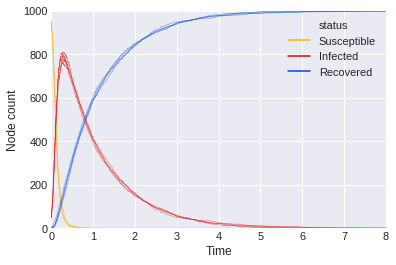

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')

# Seaborn plot
ax = plt.gca()
colours = ["amber", "red", "blue"]
sns.set_palette(sns.xkcd_palette(colours))
sns.lineplot(x="time_adj", y="node_count",
             hue="status",
             units="model_run", estimator=None,
             data=output_long,
             hue_order=["Susceptible", "Infected", "Recovered"],
             lw=0.5, alpha=5/(runs + 4),
             ax=ax)
plt.axis([0,8,0,1000])
plt.xlabel("Time")
plt.ylabel("Node count")

### It looks like the model generates the expected SIR dynamics.